# Seminar 2

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import pytensor
import pytensor.tensor as pt
import warnings
warnings.filterwarnings("ignore")
az.style.use("arviz-white")

$$
Y = A L^\beta
$$

In [2]:
np.random.seed(42)
β = 0.5
Lm = np.linspace(10, 40, 6)
A = 15/Lm

L = np.exp(np.random.normal(np.log(Lm), 0.4, size=(20, len(Lm))))
Y = A * L ** β
Y += np.random.randn(*Y.shape) * 0.5
data = pd.DataFrame(dict(
    L=L.T.flatten(), Y=Y.T.flatten(), G=np.repeat(range(len(Lm)), Y.shape[0])
))

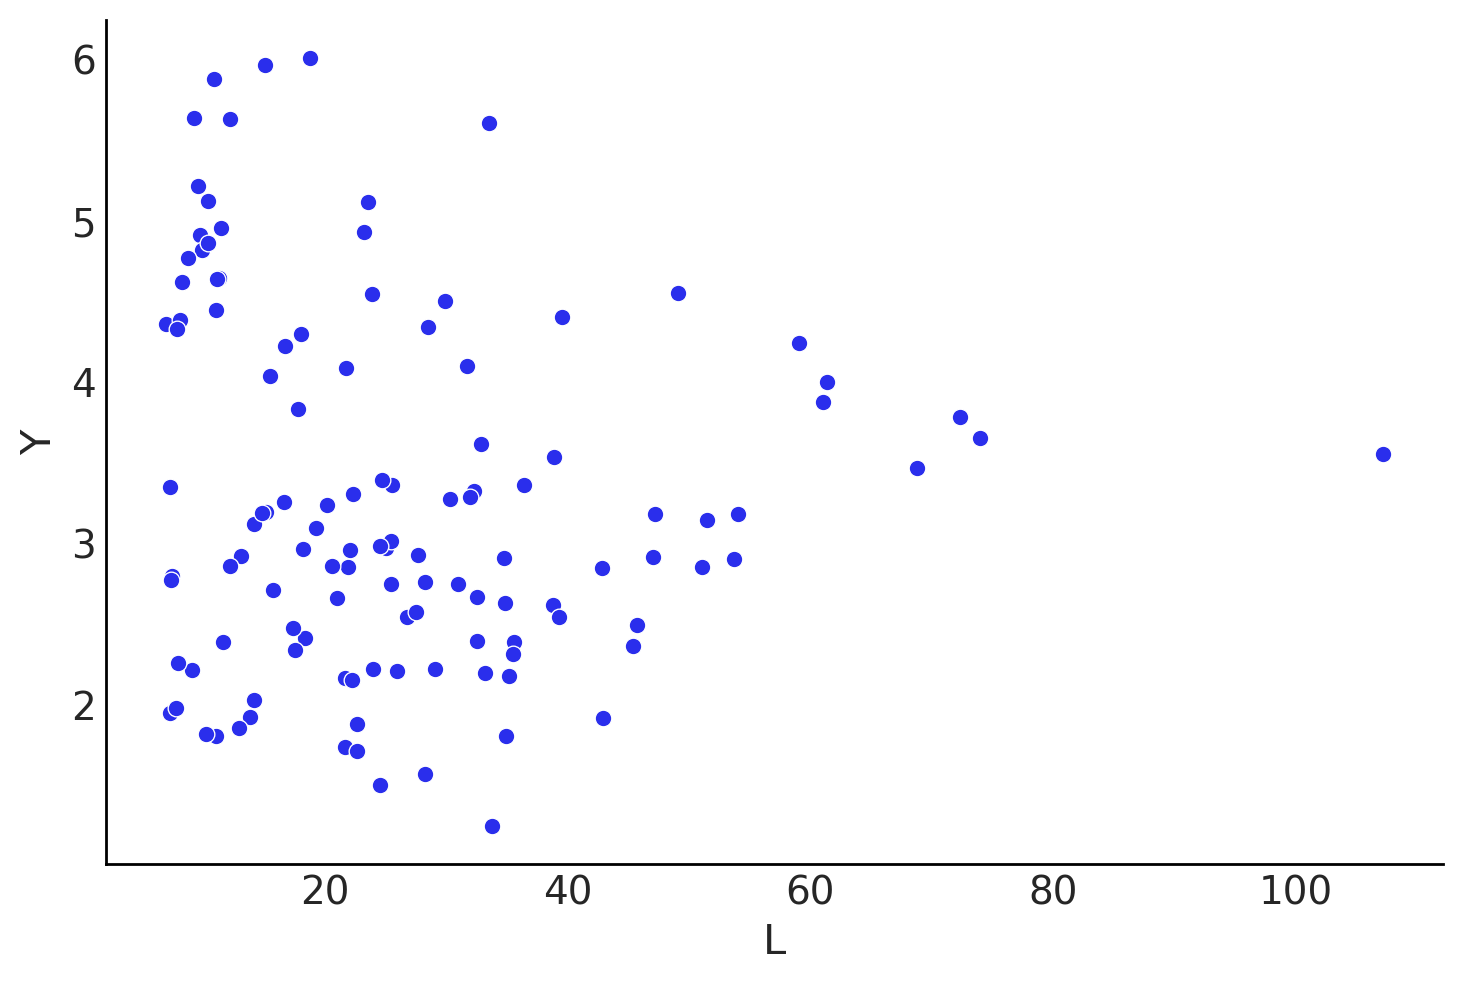

In [3]:
sns.scatterplot(x="L", y="Y", data=data);

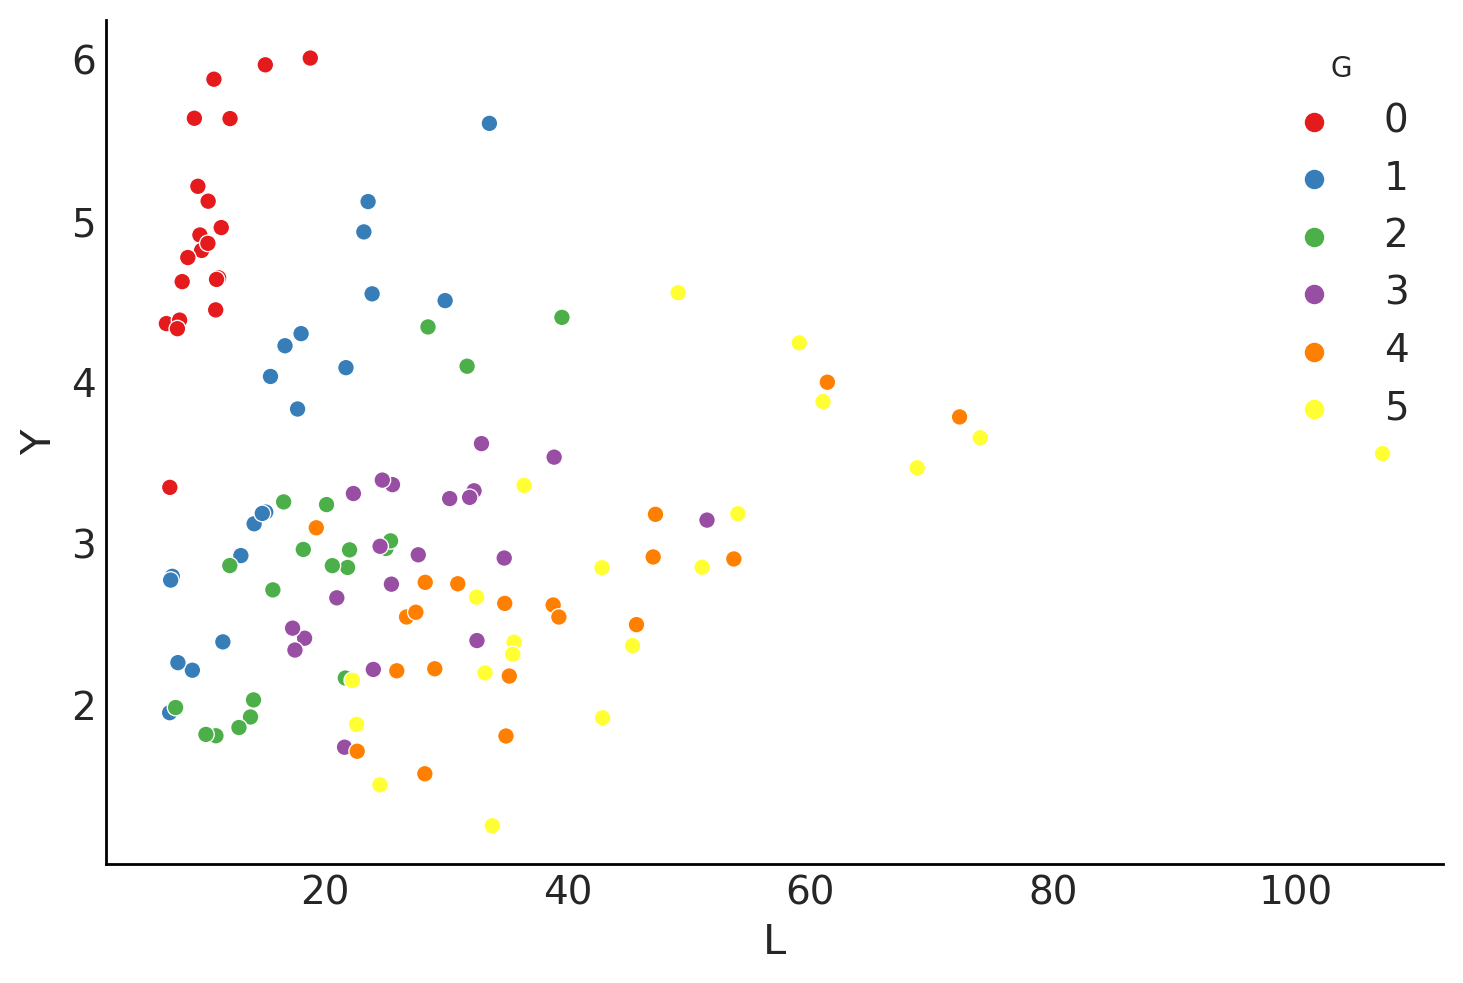

In [4]:
sns.scatterplot(x="L", y="Y", hue="G", data=data, palette="Set1");

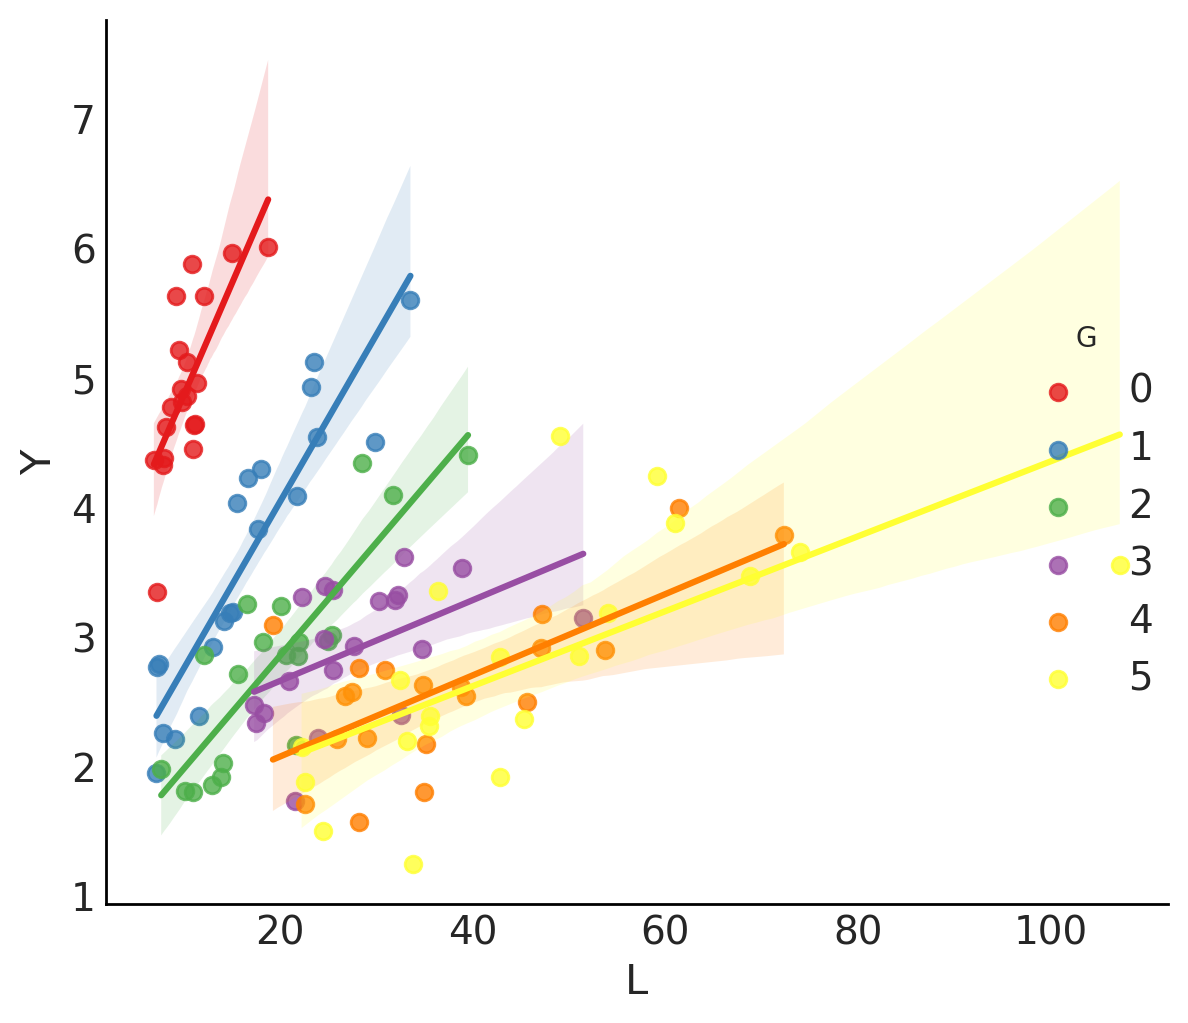

In [5]:
sns.lmplot(x="L", y="Y", hue="G", data=data, palette="Set1");

[]

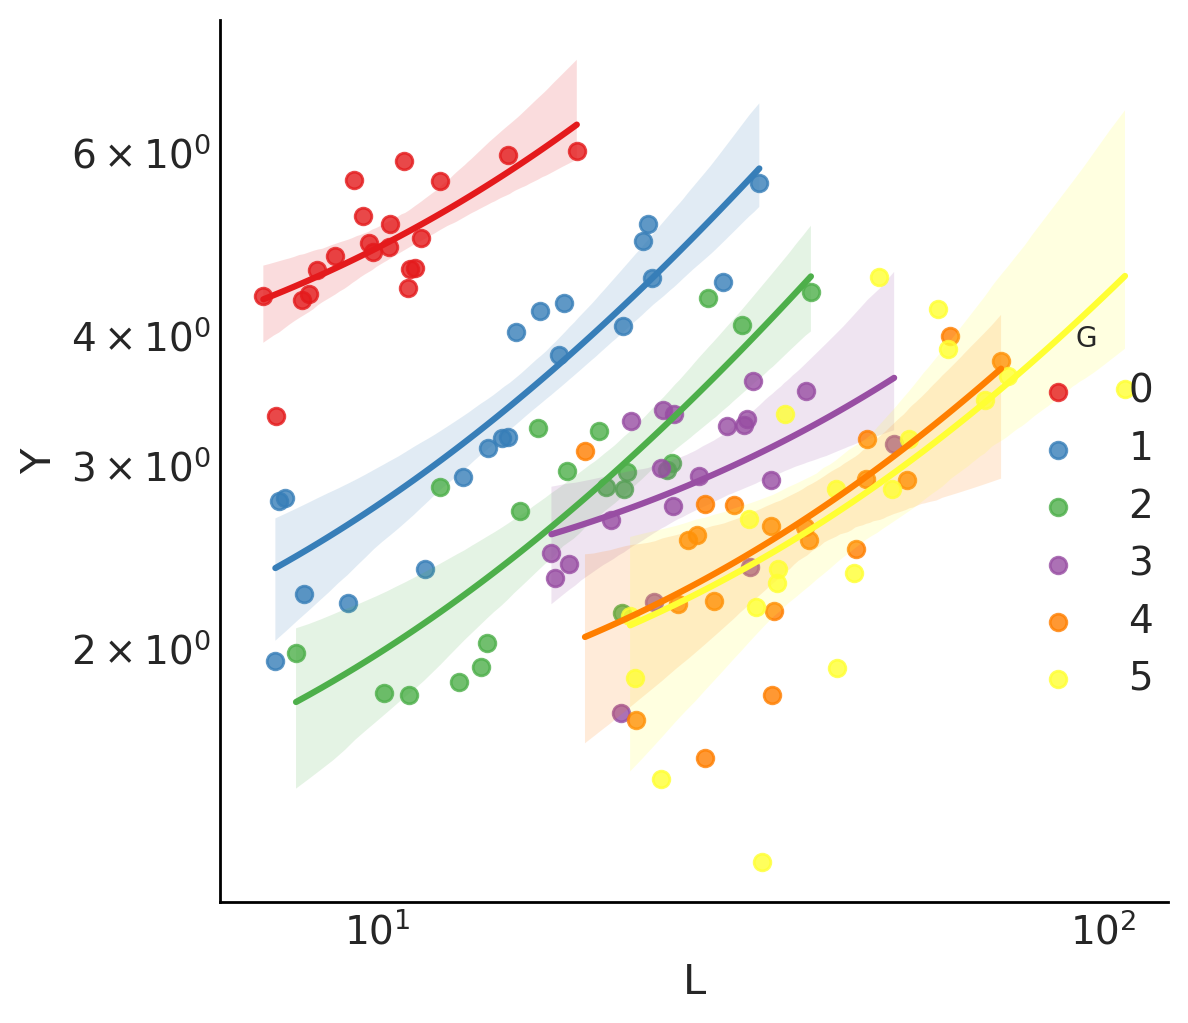

In [6]:
sns.lmplot(x="L", y="Y", hue="G", data=data, palette="Set1");
plt.loglog()

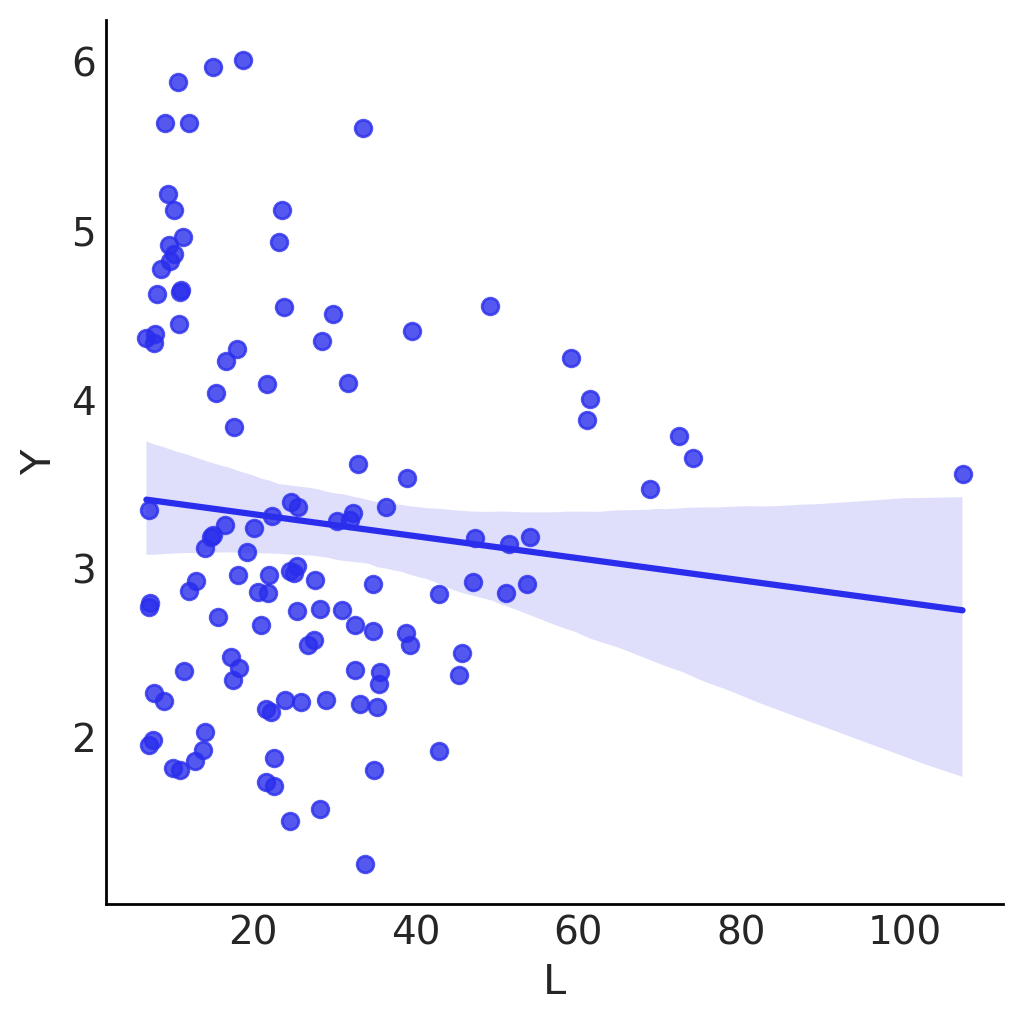

In [7]:
sns.lmplot(x="L", y="Y", data=data);

## One Group Model

### Priors

<Axes: ylabel='Density'>

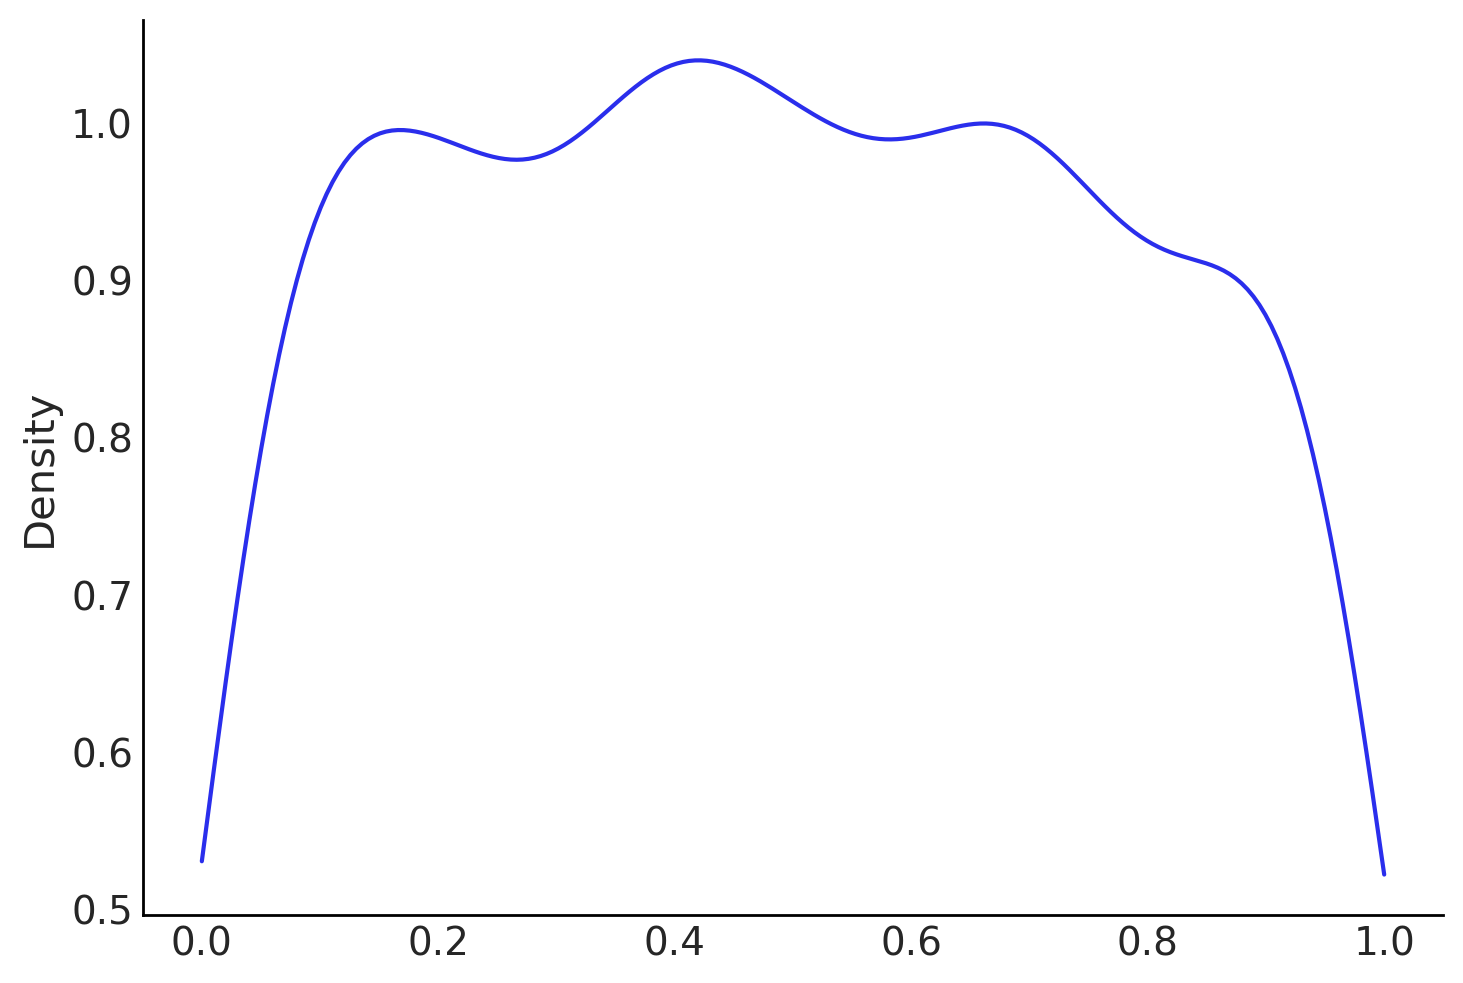

In [8]:
sns.kdeplot(pm.Uniform.dist(size=1000).eval(), clip=[0, 1])

<Axes: ylabel='Density'>

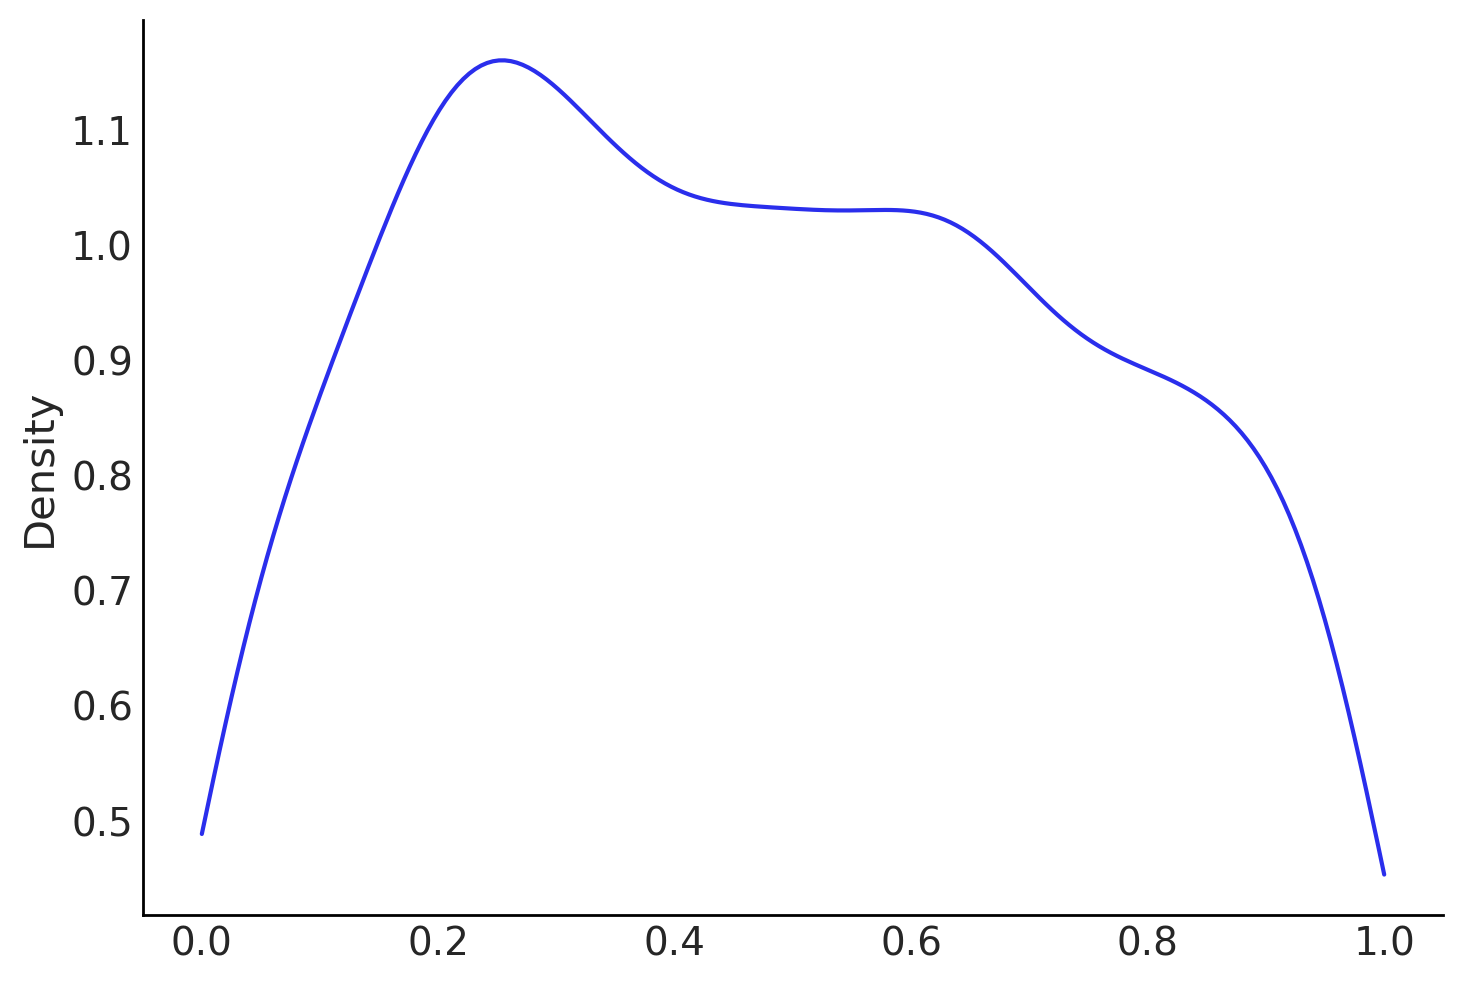

In [9]:
sns.kdeplot(pm.Beta.dist(1, 1, size=1000).eval(), clip=[0, 1])

<Axes: ylabel='Density'>

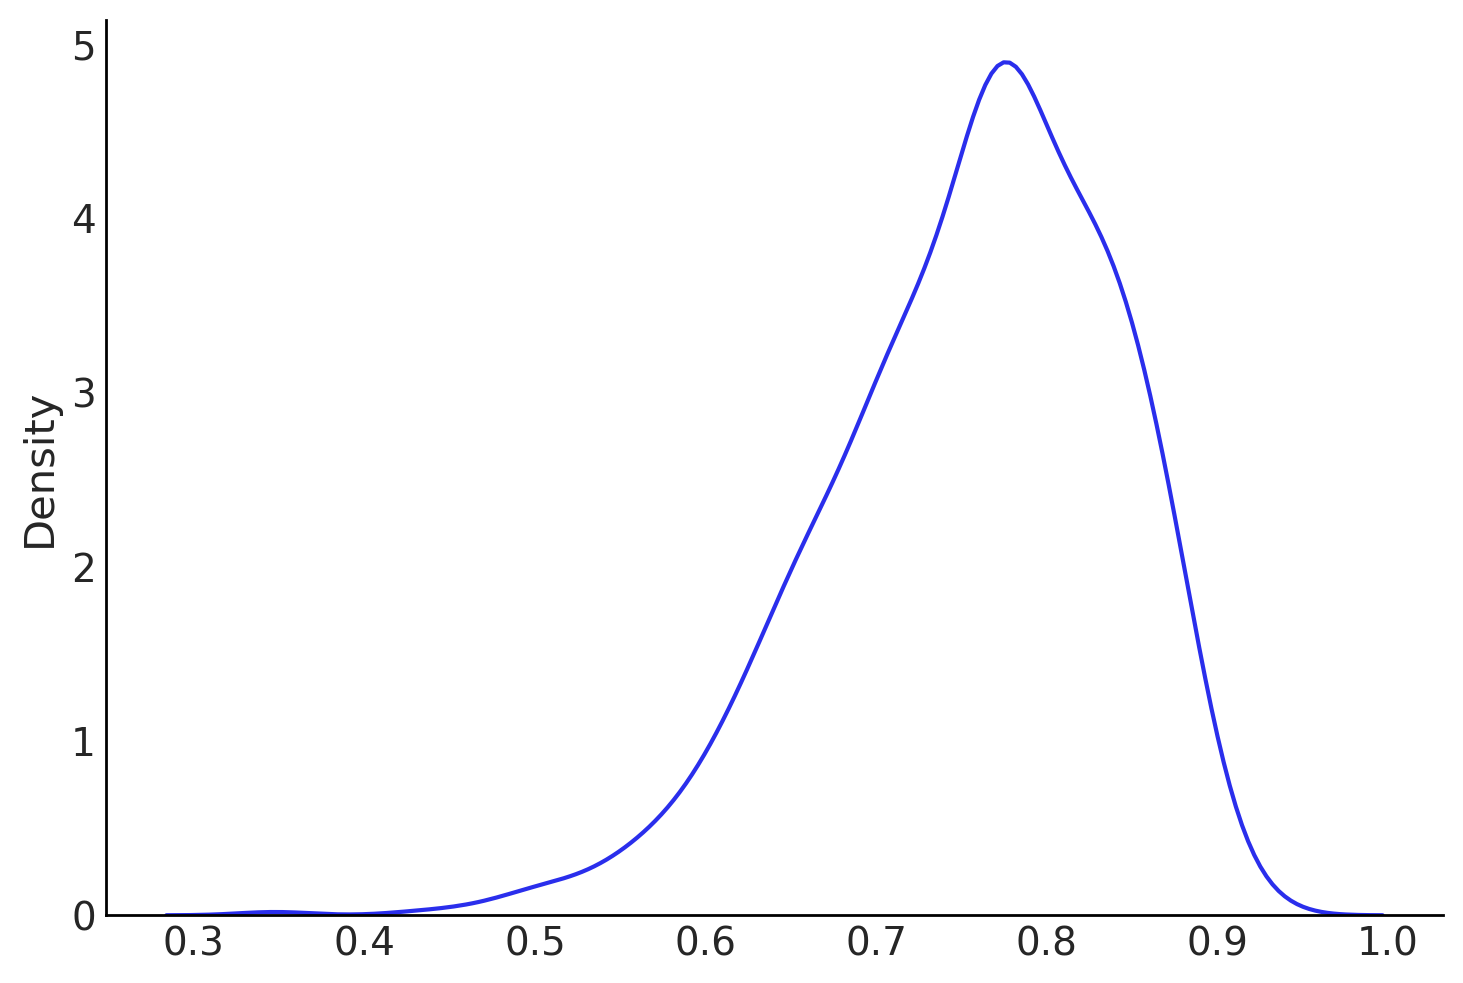

In [10]:
sns.kdeplot(pm.Kumaraswamy.dist(10, 10, size=1000).eval(), clip=[0, 1])

<Axes: ylabel='Density'>

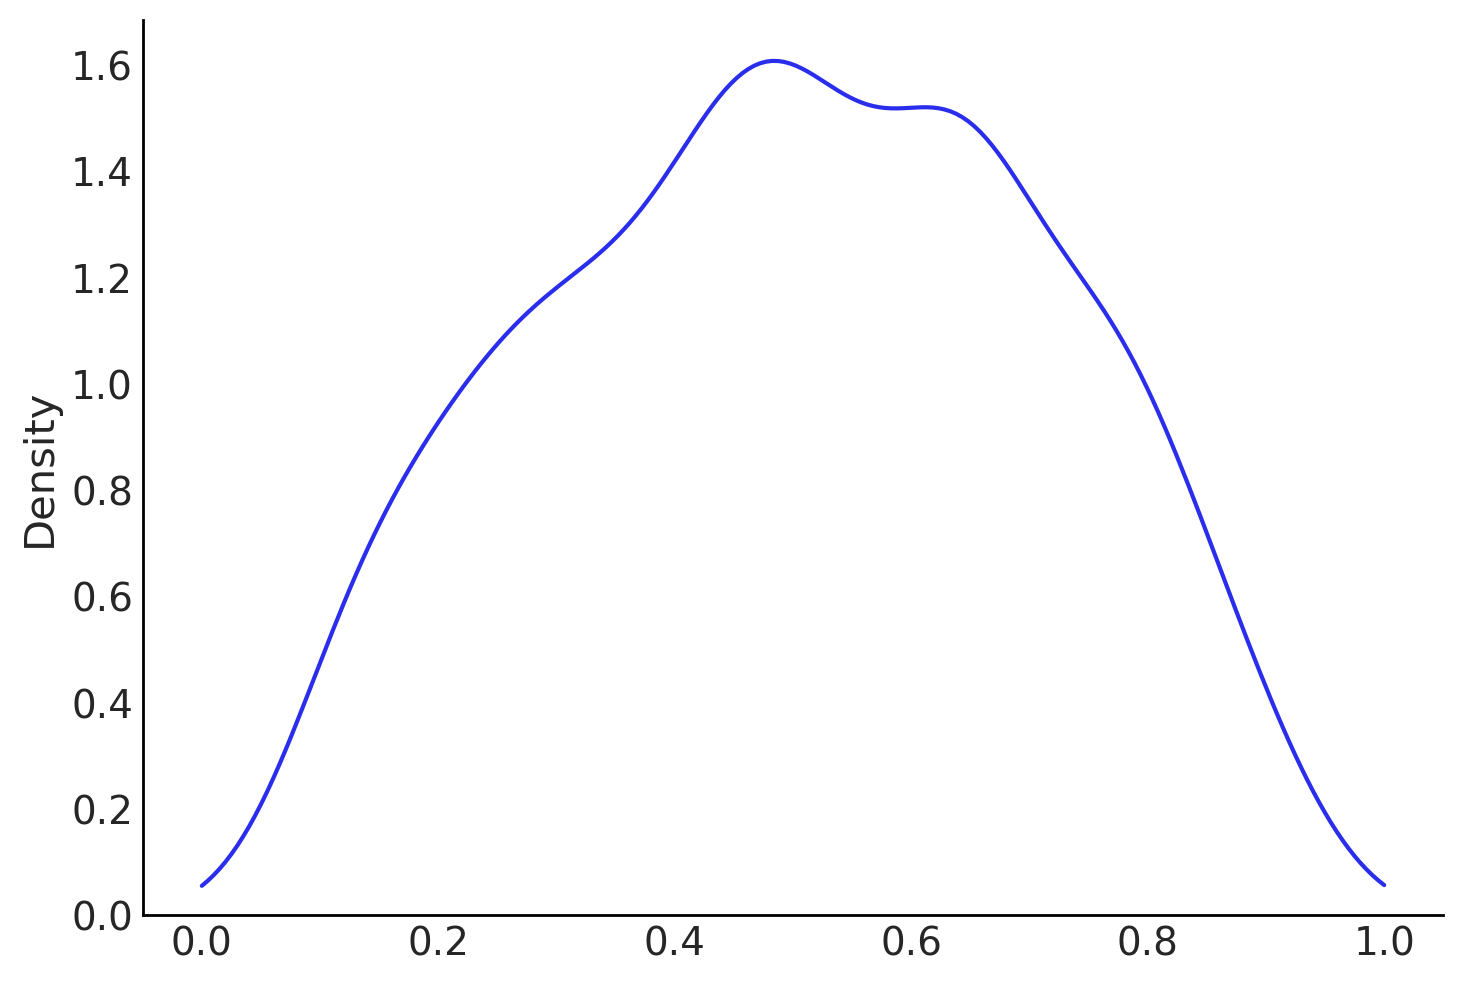

In [11]:
sns.kdeplot(pm.LogitNormal.dist(size=1000).eval(), clip=[0, 1])

In [12]:
opt_params = pm.find_constrained_prior(
    pm.Gamma, lower=0.1, upper=0.4, mass=0.75, init_guess={"alpha": 1, "beta": 10}
)

In [58]:
opt_params

{'alpha': 3.1204120571973584, 'beta': 12.734037400345912}

In [59]:
opt_params = pm.find_constrained_prior(
    pm.LogNormal, lower=0.05, upper=0.15, mass=0.95, init_guess={"mu": 0, "sigma": 1}
)

In [62]:
opt_params

{'mu': -2.696644818812513, 'sigma': 0.18182645802436778}

In [61]:
np.exp(opt_params["mu"])

0.06743137810952435

In [63]:
with pm.Model() as model:
    sigma = pm.LogNormal("σ", **opt_params)

In [64]:
model

σ ~ LogNormal(-2.7, 0.182)

$$
\begin{align*}
    \log Y_{g=0} &\sim \operatorname{Normal}(\log A_{g=0} + \log L \cdot \beta, \varepsilon)\\
    \varepsilon &\sim \operatorname{LogNormal}(-2, 1)\\
    \beta &\sim \operatorname{LogitNormal}(0, 1)\\
    A_{g=0} &\sim \operatorname{LogNormal}(0, 1)\\
\end{align*}
$$

In [13]:
data0 = data.query("G==0")

In [14]:
data0

L         Y  G
0   12.197985  5.634358  0
1   18.807773  6.009921  0
2   11.016234  4.447455  0
3    6.954406  4.362440  0
4    8.043240  4.384032  0
5    7.860911  4.330844  0
6   10.871346  5.878646  0
7    9.547943  5.214260  0
8   11.473413  4.958170  0
9   15.104382  5.967999  0
10   8.255795  4.622769  0
11   9.716068  4.912210  0
12   9.857718  4.816597  0
13  10.373862  4.860376  0
14   7.236862  3.346378  0
15  10.395948  5.121857  0
16  11.257485  4.646414  0
17   8.718954  4.772311  0
18  11.085138  4.636501  0
19   9.259413  5.636365  0

In [66]:
with pm.Model() as model1:
    a = pm.LogNormal("A", 0, 1)
    b = pm.LogitNormal("beta", 0, 1)
    e = pm.LogNormal("e", -2, 1)
    y = pm.LogNormal("obs", at.log(a) + np.log(data0.L), e, observed=data0.Y)

In [67]:
with model1:
    prior = pm.sample_prior_predictive()

Sampling: [A, beta, e, obs]


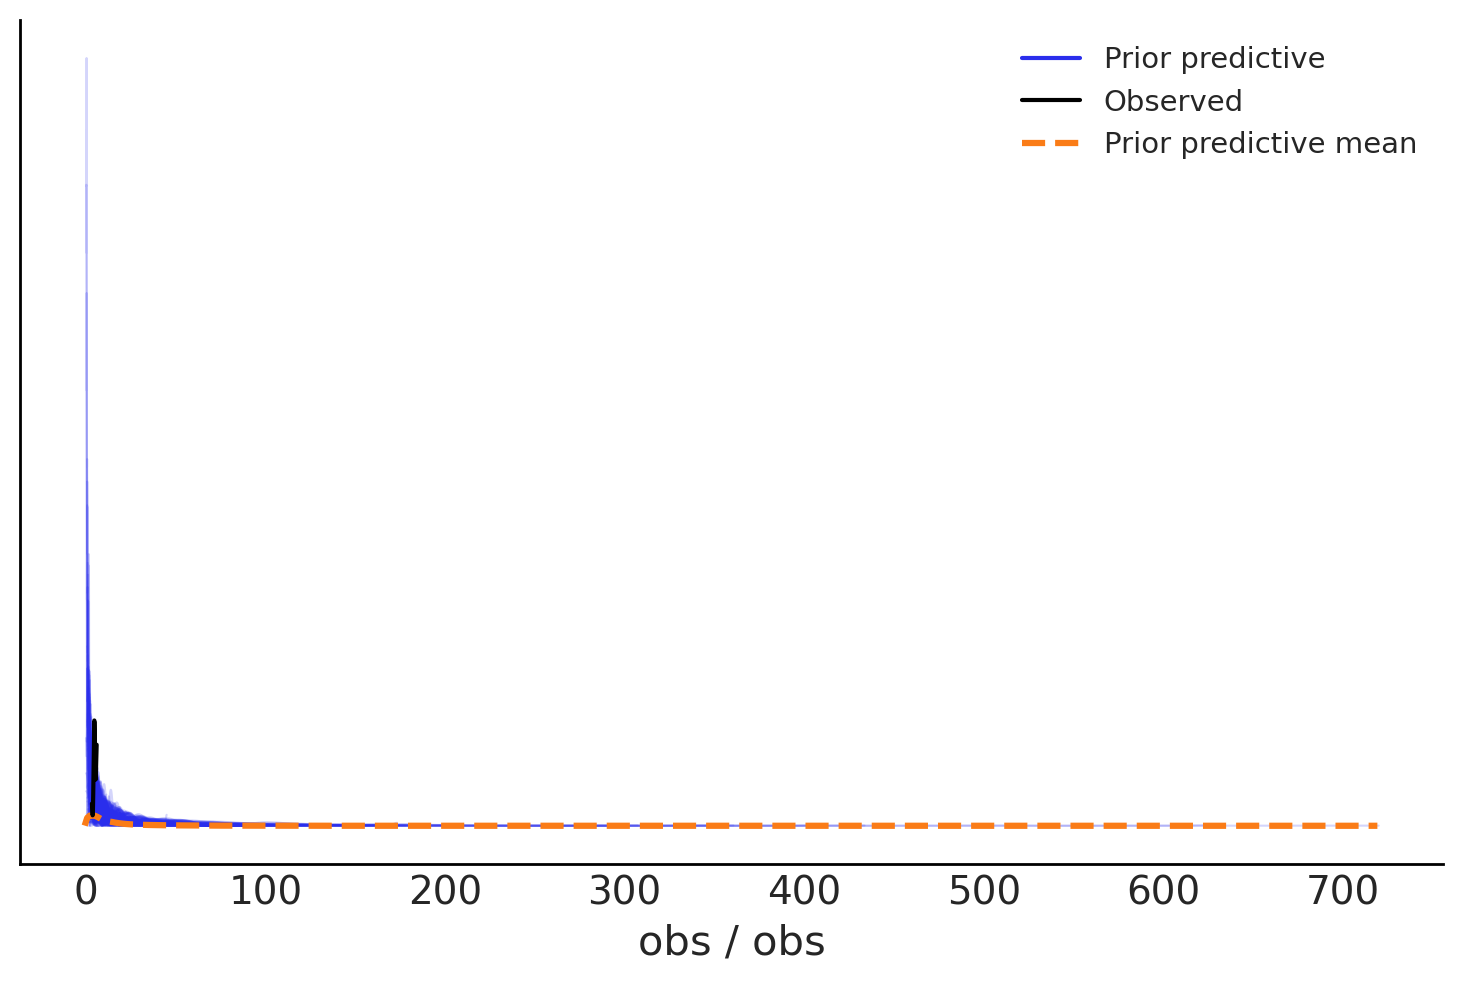

In [68]:
az.plot_ppc(prior, group="prior");

In [69]:
with model1:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, beta, e]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


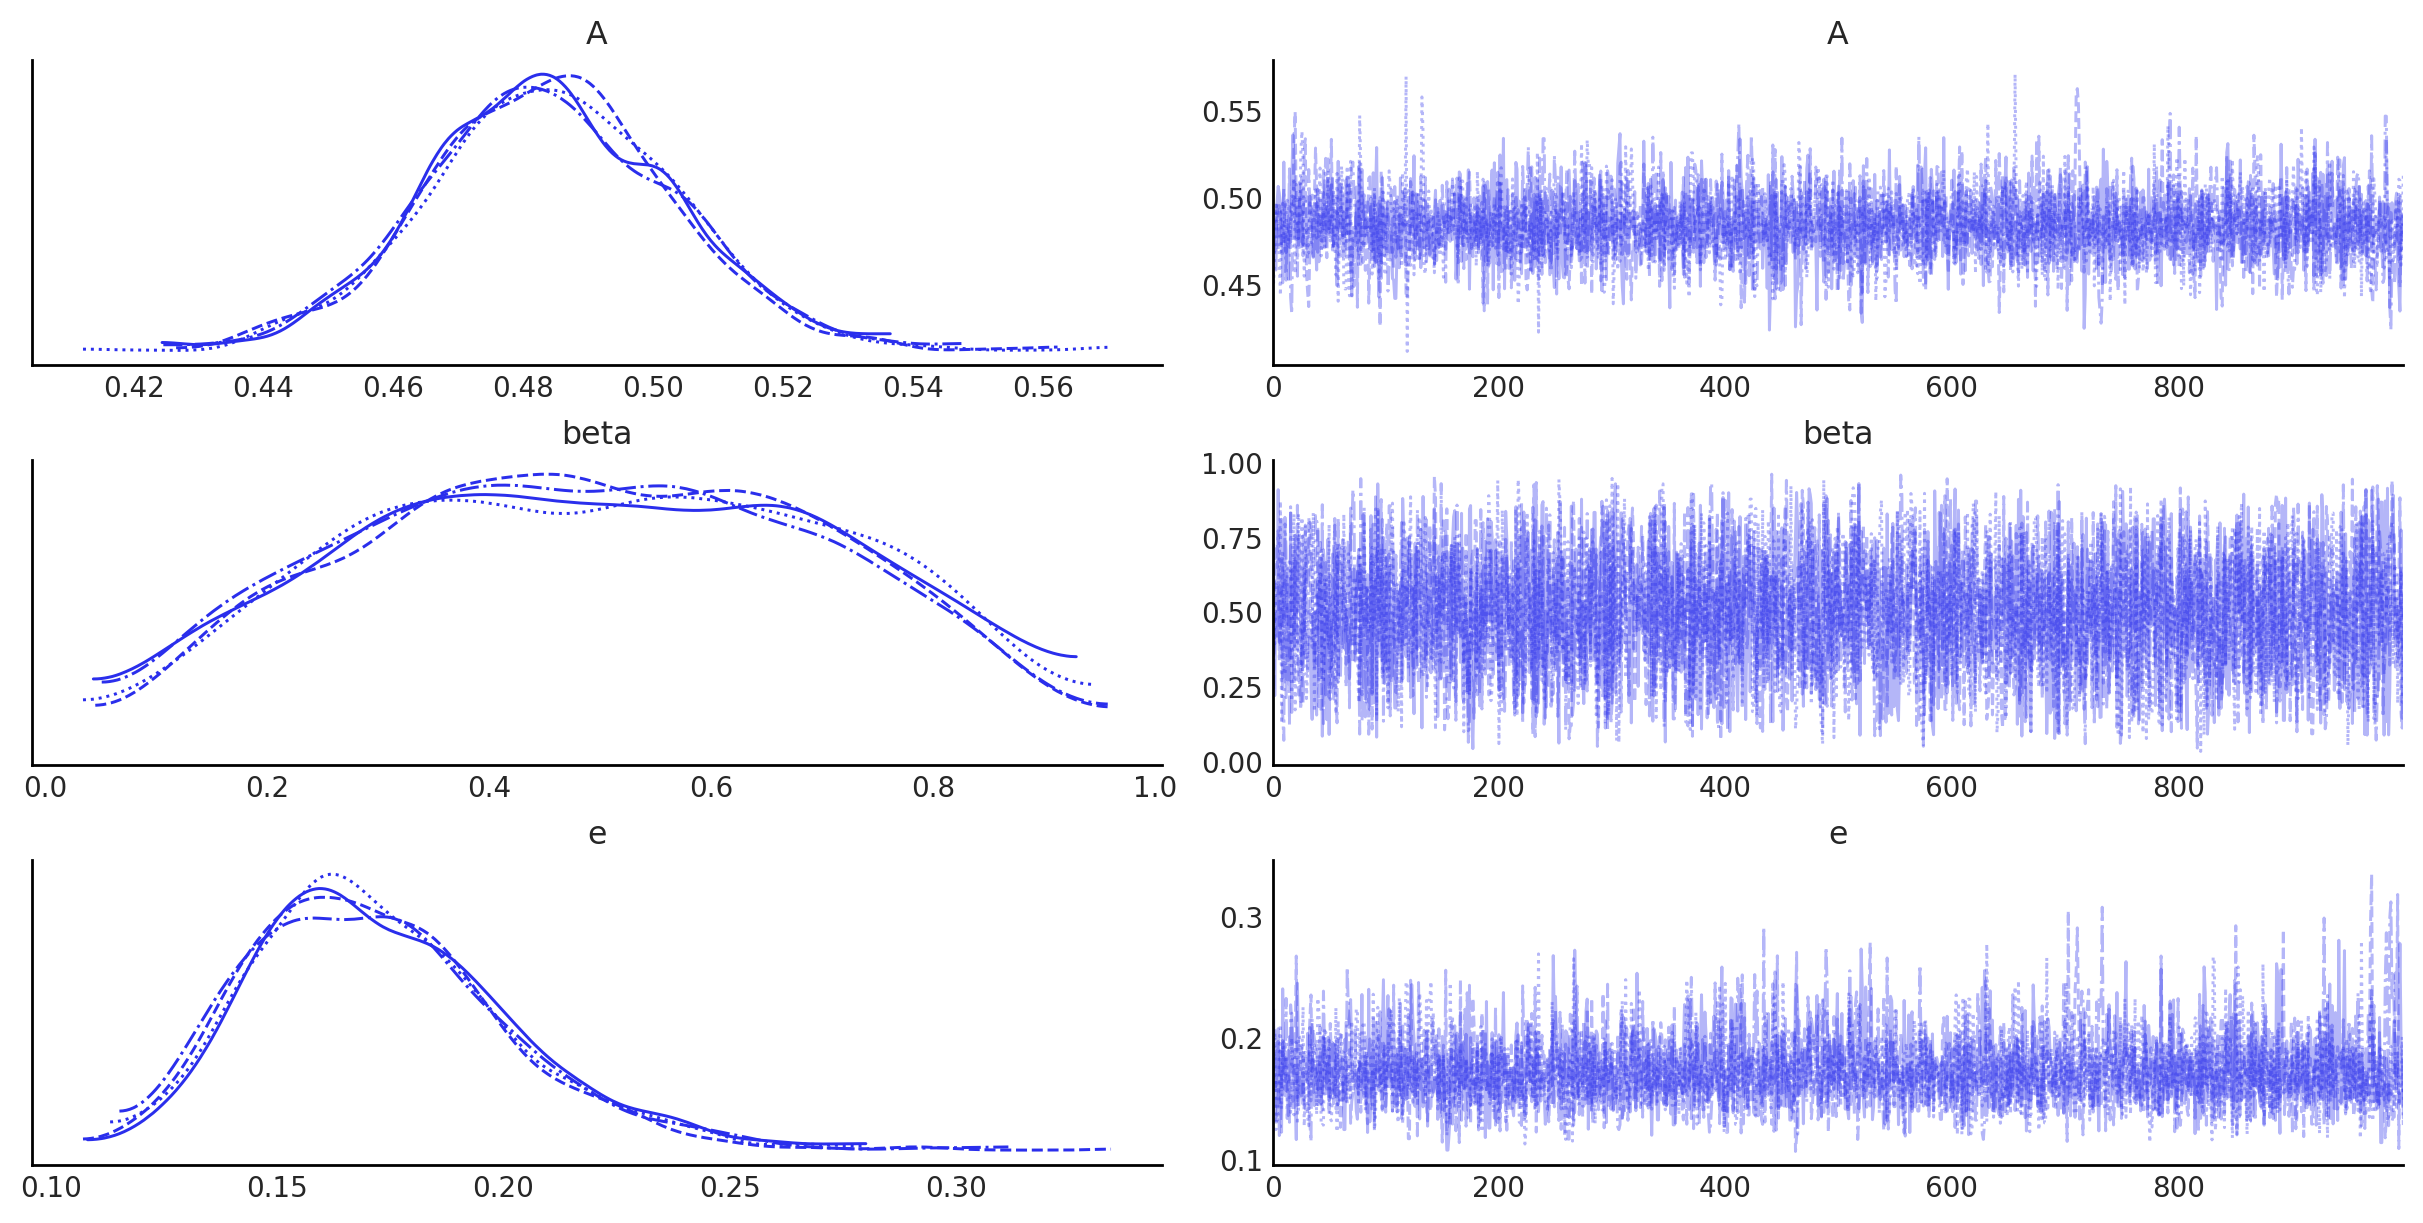

In [25]:
az.plot_trace(trace);

### Fixing Priors

Sampling: [A, beta, e, obs]


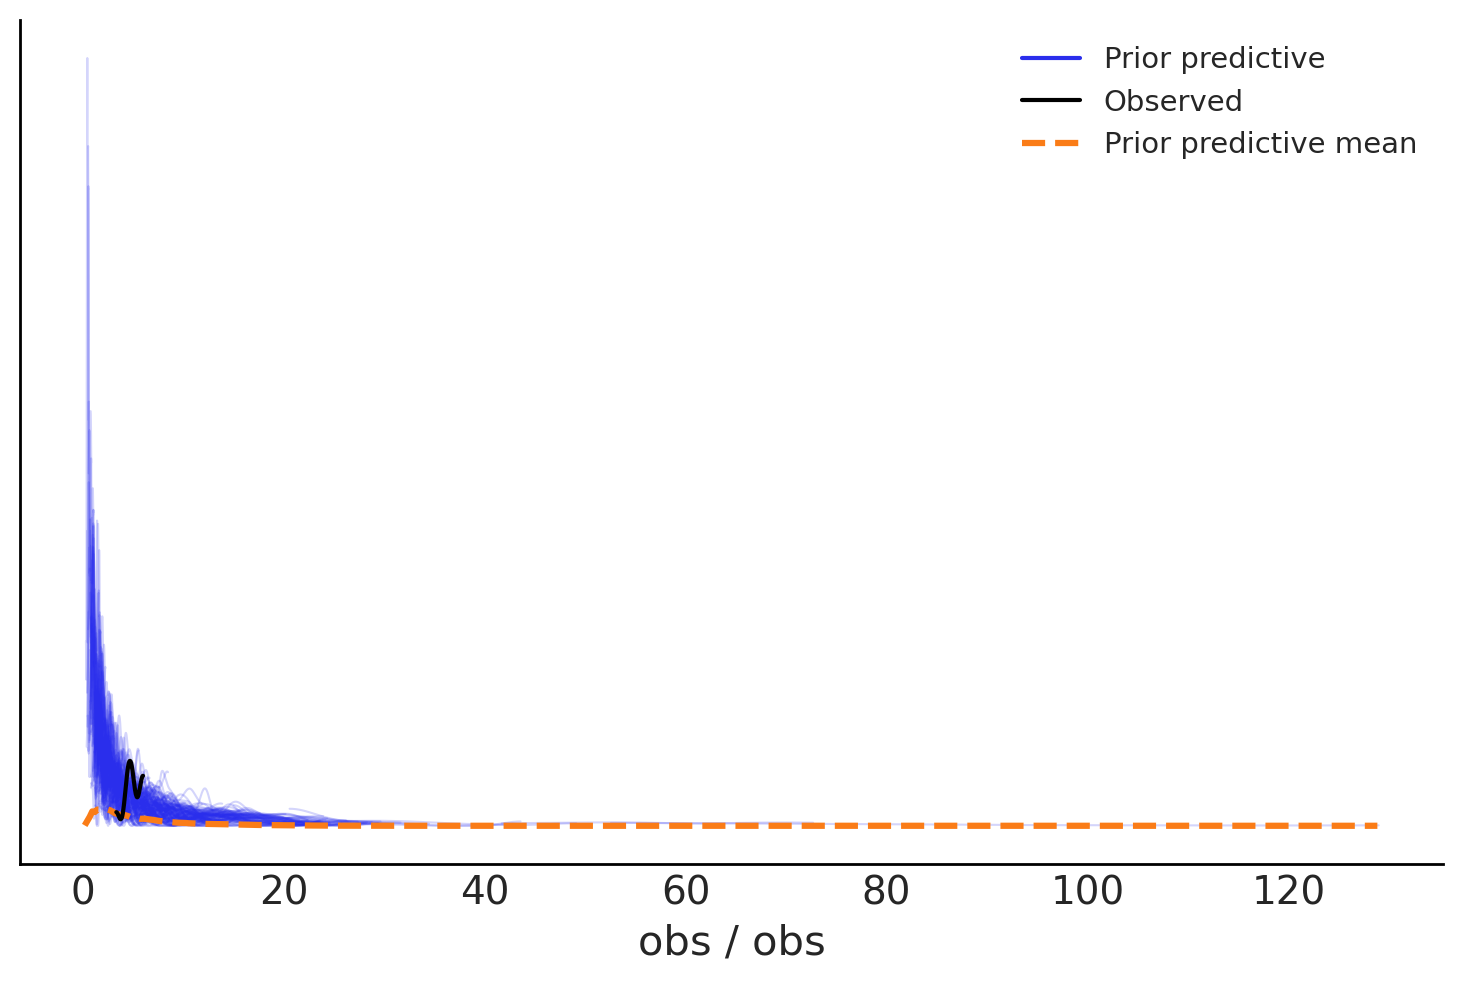

In [15]:
with pm.Model() as model1:
    a = pm.LogNormal("A", **pm.find_constrained_prior(pm.LogNormal, lower=0.5, upper=20, mass=0.95, init_guess={"mu": 0, "sigma": 1}))
    b = pm.LogitNormal("beta", 0, 1)
    e = pm.LogNormal("e", -2, 0.1)
    mu = pm.Deterministic("mu", pt.log(a) + b*np.log(data0.L))
    y = pm.LogNormal("obs", mu, e, observed=data0.Y)
    prior = pm.sample_prior_predictive()
    az.plot_ppc(prior, group="prior");

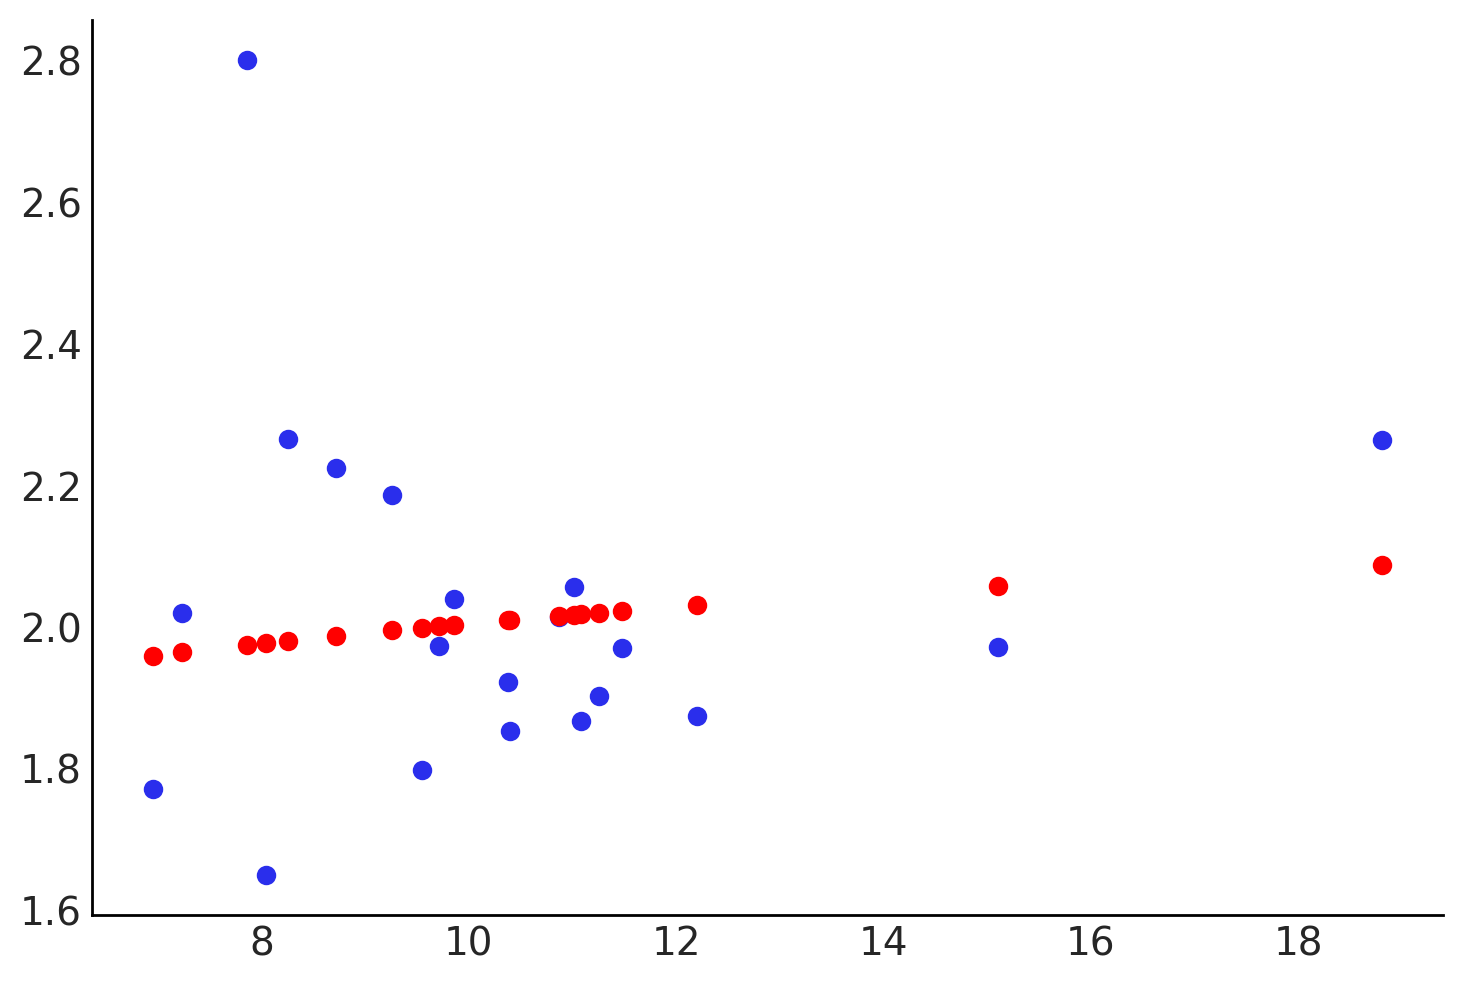

In [16]:
plt.scatter(data0.L, prior.prior_predictive["obs"].sel(chain=0, draw=5));
plt.scatter(data0.L, np.exp(prior.prior["mu"].sel(chain=0, draw=5)), color="red");

In [26]:
with pm.do(model1, {"e": 0.1, "beta": 0.01}):
    prior1 = pm.sample_prior_predictive(1)

Sampling: [A, obs]


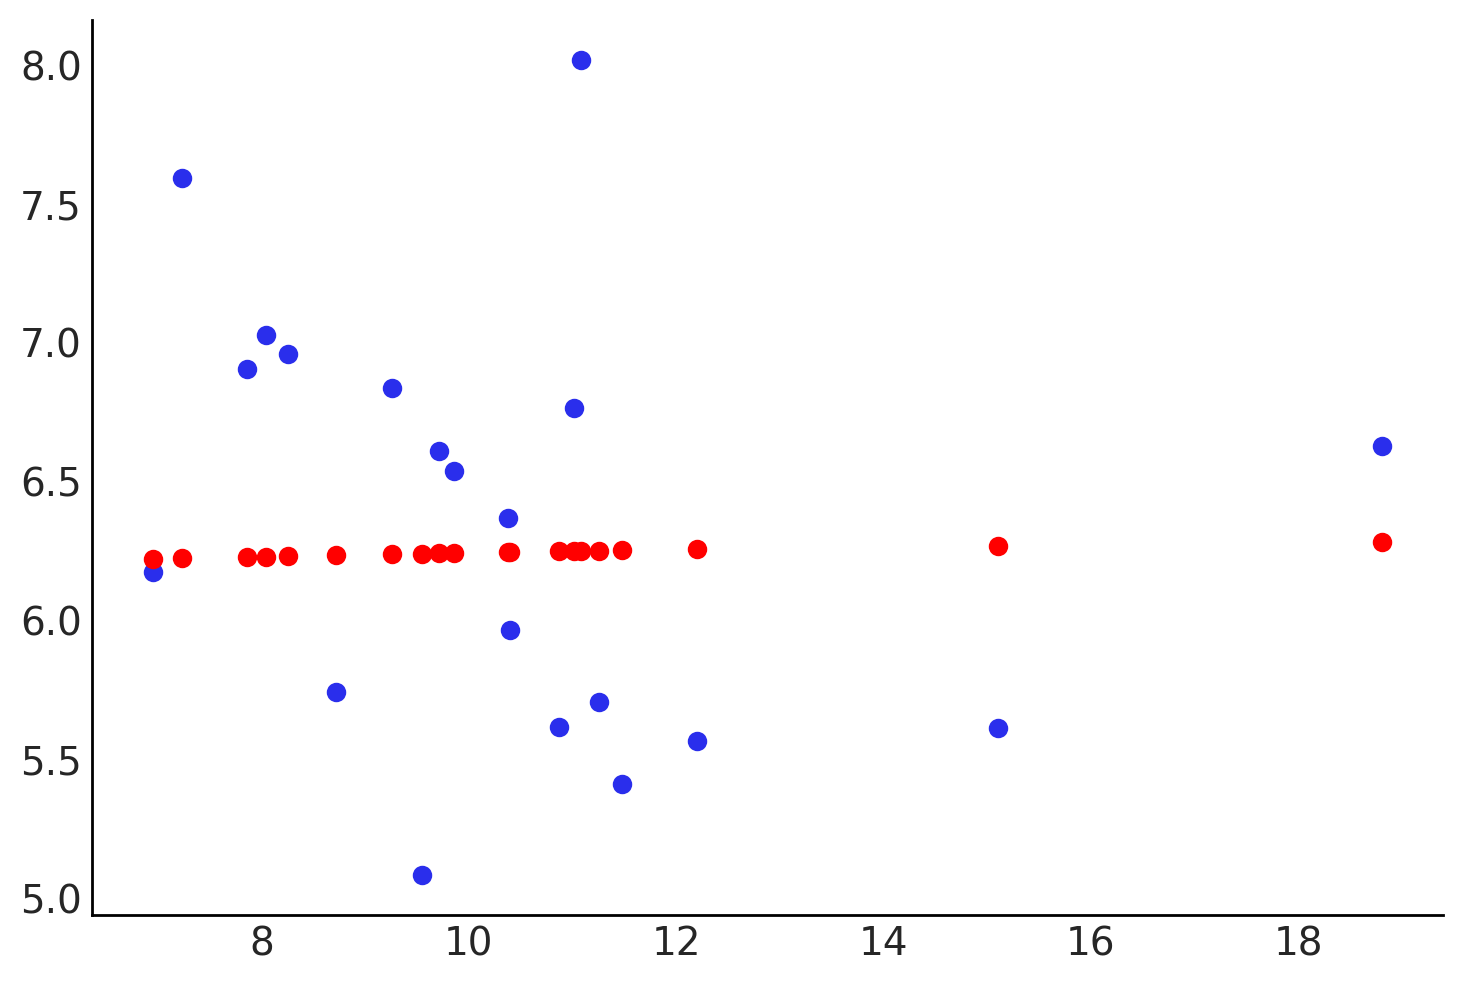

In [27]:
plt.scatter(data0.L, prior1.prior_predictive["obs"].sel(chain=0, draw=0));
plt.scatter(data0.L, np.exp(prior1.prior["mu"].sel(chain=0, draw=0)), color="red");

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, beta, e]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


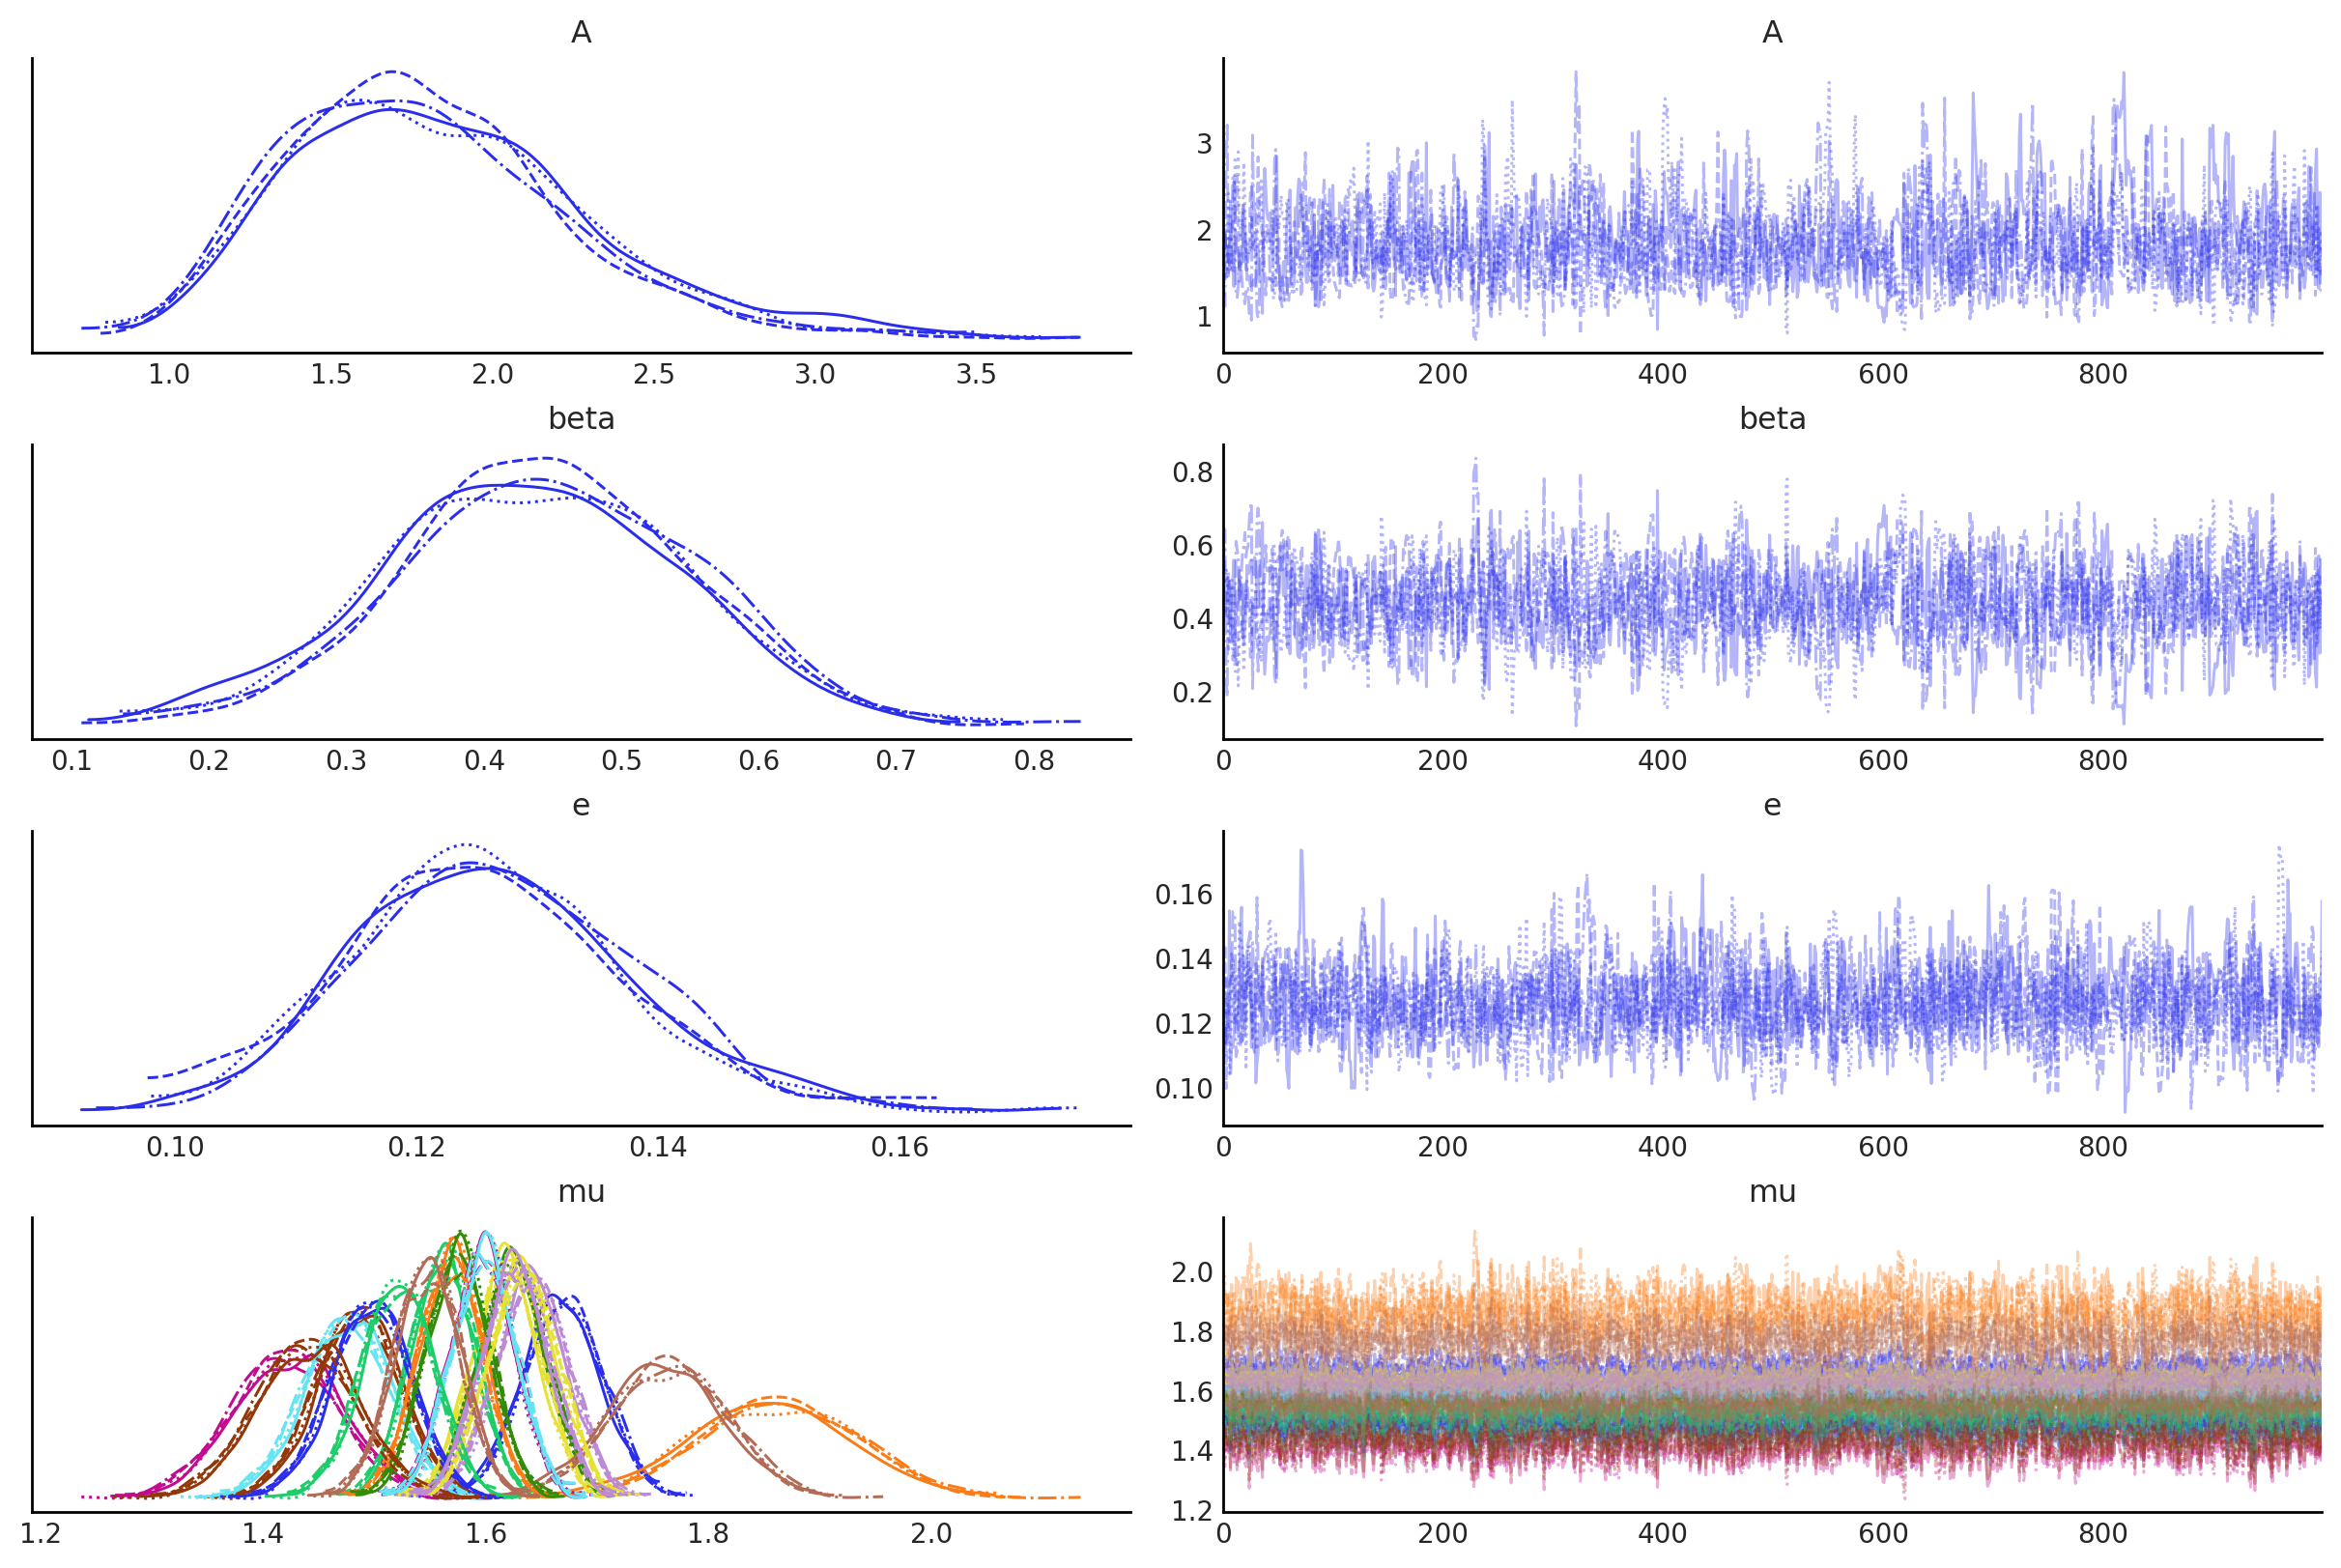

In [29]:
with model1:
    trace = pm.sample(target_accept=0.9)
    az.plot_trace(trace)

## Neal's Funnel

$$
\begin{align}
s &\sim \operatorname{HalfCauchy}(1)\\
m &\sim \operatorname{Normal}(0, s)
\end{align}
$$

In [36]:
with pm.Model() as neals_funnel:
    s = pm.Exponential("s", 1)
    m = pm.Normal("m", 0, s)
    trace = pm.sample(target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


In [37]:
az.ess(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    m        float64 576.0
    s        float64 368.0

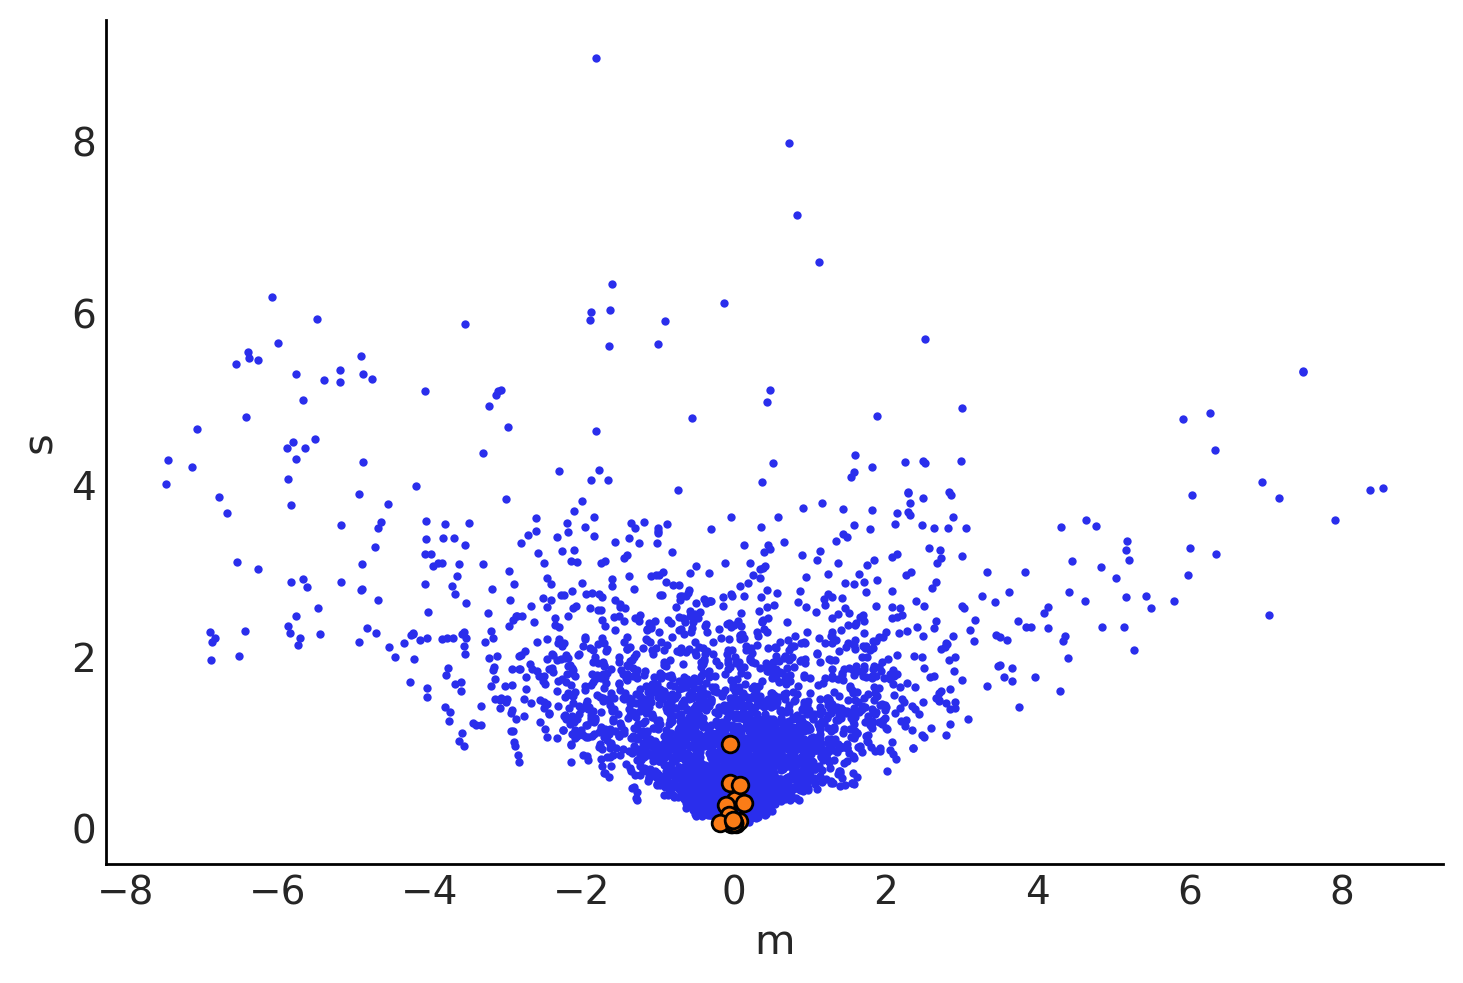

In [32]:
az.plot_pair(trace, divergences=True);

In [35]:
with pm.Model() as no_neals_funnel:
    s = pm.Exponential("s", 1)
    m = pm.Deterministic("m", pm.Normal("mhat") * s)
    trace1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, mhat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [38]:
az.ess(trace1)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mhat     float64 2.127e+03
    s        float64 2.459e+03
    m        float64 1.995e+03

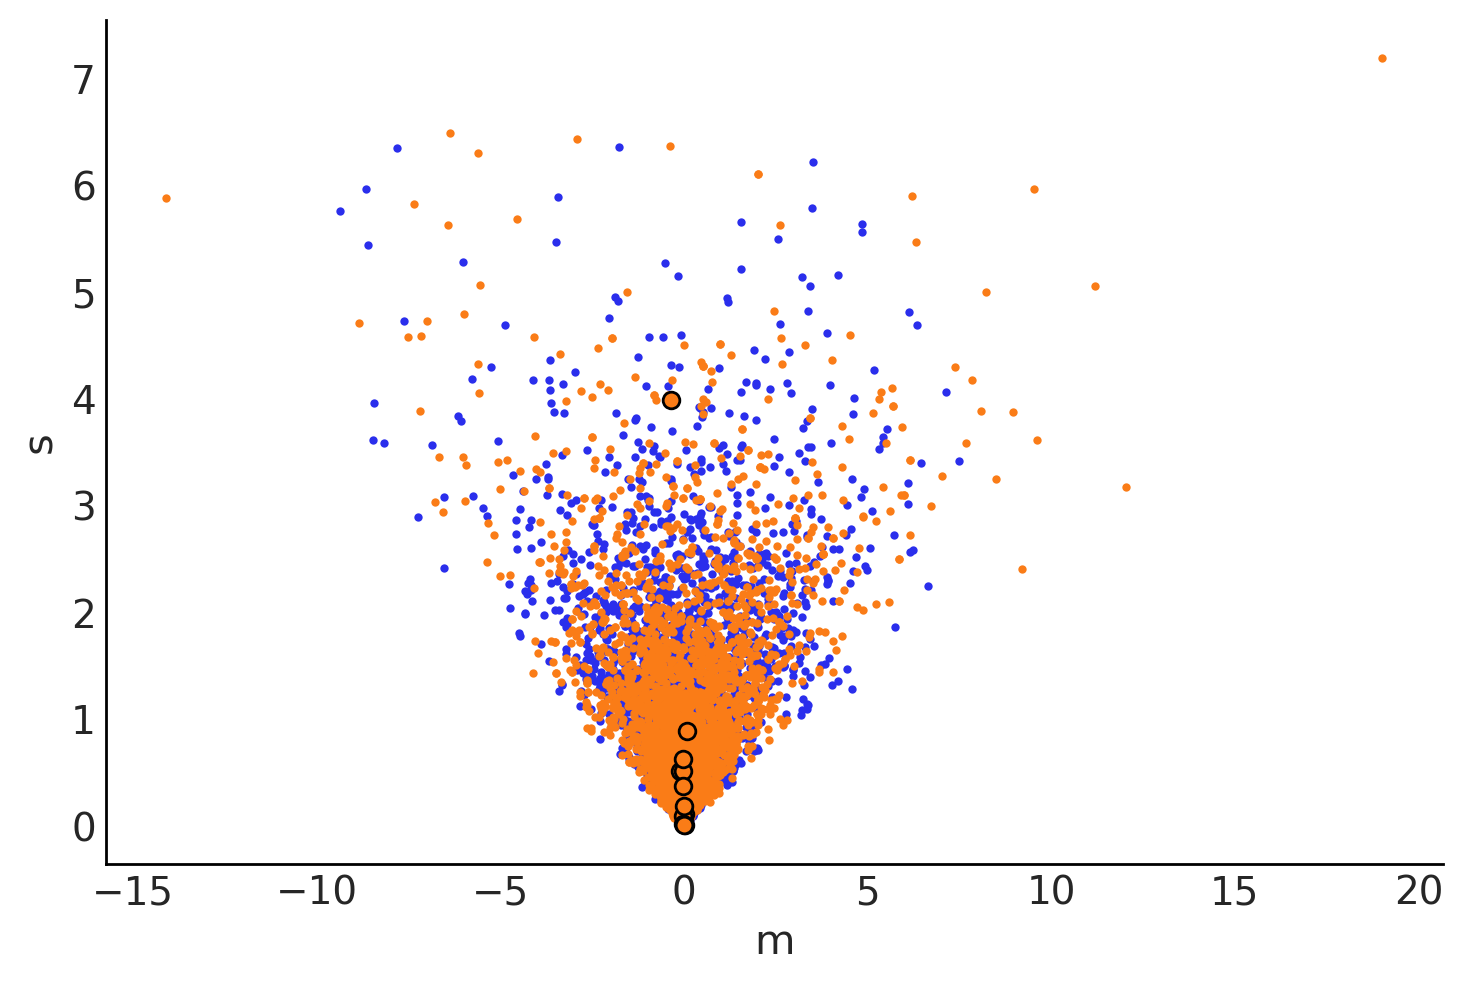

In [40]:
ax = az.plot_pair(trace, var_names=["m", "s"], divergences=True);
az.plot_pair(trace1, var_names=["m", "s"], divergences=True, ax=ax);

$$
\begin{align}
s &\sim \operatorname{HalfCauchy}(1)\\
\bar m &\sim \operatorname{Normal}(0, 1)\\
m &= s \bar m
\end{align}
$$

## Hierarchical Model

In [43]:
idx, index = pd.factorize(data.G)
idx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [47]:
?pm.do

Signature:
pm.do(
    model: pymc.model.core.Model,
    vars_to_interventions: Mapping[Union[ForwardRef('str'), pytensor.tensor.variable.TensorVariable], Any],
    prune_vars=False,
) -> pymc.model.core.Model
Docstring:
Replace model variables by intervention variables.

Intervention variables will either show up as `Data` or `Deterministics` in the new model,
depending on whether they depend on other RandomVariables or not.

Parameters
----------
model: PyMC Model
vars_to_interventions: Dict of variable or name to TensorLike
    Dictionary that maps model variables (or names) to intervention expressions.
    Intervention expressions must have a shape and data type that is compatible
    with the original model variable.
prune_vars: bool, defaults to False
    Whether to prune model variables that are not connected to any observed variables,
    after the interventions.

Returns
-------
new_model: PyMC model
    A distinct PyMC model with the relevant variables replaced by the interven

In [90]:
g_index, g_coord = pd.factorize(data.G)

In [91]:
g_index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [94]:
fff = np.random.randn(6)

In [97]:
fff[g_index]

array([-0.70729338, -0.70729338, -0.70729338, -0.70729338, -0.70729338,
       -0.70729338, -0.70729338, -0.70729338, -0.70729338, -0.70729338,
       -0.70729338, -0.70729338, -0.70729338, -0.70729338, -0.70729338,
       -0.70729338, -0.70729338, -0.70729338, -0.70729338, -0.70729338,
        0.12536532,  0.12536532,  0.12536532,  0.12536532,  0.12536532,
        0.12536532,  0.12536532,  0.12536532,  0.12536532,  0.12536532,
        0.12536532,  0.12536532,  0.12536532,  0.12536532,  0.12536532,
        0.12536532,  0.12536532,  0.12536532,  0.12536532,  0.12536532,
        1.16139879,  1.16139879,  1.16139879,  1.16139879,  1.16139879,
        1.16139879,  1.16139879,  1.16139879,  1.16139879,  1.16139879,
        1.16139879,  1.16139879,  1.16139879,  1.16139879,  1.16139879,
        1.16139879,  1.16139879,  1.16139879,  1.16139879,  1.16139879,
       -0.81125712, -0.81125712, -0.81125712, -0.81125712, -0.81125712,
       -0.81125712, -0.81125712, -0.81125712, -0.81125712, -0.81

In [99]:
np.repeat(fff, [10, 2, 5, 2, 5, 9])

array([-0.70729338, -0.70729338, -0.70729338, -0.70729338, -0.70729338,
       -0.70729338, -0.70729338, -0.70729338, -0.70729338, -0.70729338,
        0.12536532,  0.12536532,  1.16139879,  1.16139879,  1.16139879,
        1.16139879,  1.16139879, -0.81125712, -0.81125712,  0.36860083,
        0.36860083,  0.36860083,  0.36860083,  0.36860083,  0.31572527,
        0.31572527,  0.31572527,  0.31572527,  0.31572527,  0.31572527,
        0.31572527,  0.31572527,  0.31572527])

Sampling: [A, Apop, a_sigma, beta, e, obs]


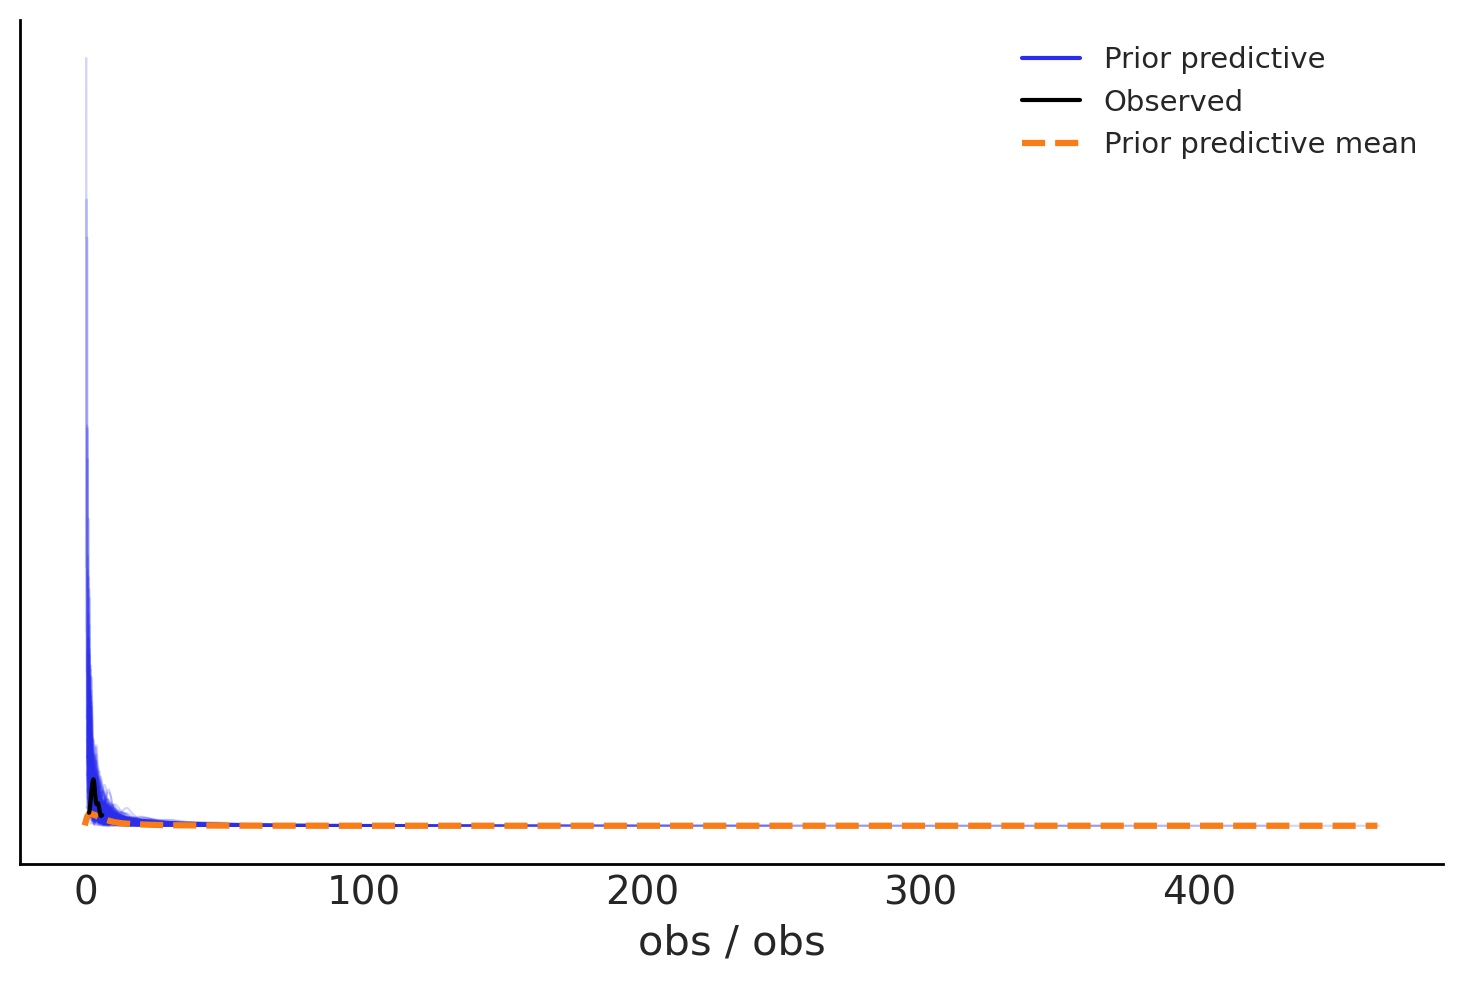

In [95]:
with pm.Model(
    coords=dict(group=index, idx=data.index)
) as model2:
    a_pop = pm.LogNormal("Apop", **pm.find_constrained_prior(pm.LogNormal, lower=0.5, upper=20, mass=0.95, init_guess={"mu": 0, "sigma": 1}))
    # a_sigma = 0.1 #  pm.Exponential("a_sibgma", 10)
    a_sigma = pm.Exponential("a_sigma", 10)
    a = pm.LogNormal("A", pt.log(a_pop), a_sigma, dims="group")
    b = pm.LogitNormal("beta", 0, 1)
    e = pm.LogNormal("e", -2, 0.1)
    mu = pm.Deterministic("mu", pt.log(a[g_index]) + b*np.log(data.L), dims="idx")
    y = pm.LogNormal("obs", mu, e, observed=data.Y, dims="idx")
    prior = pm.sample_prior_predictive()
    az.plot_ppc(prior, group="prior");

## Discrete

In [57]:
pm.Mixture?

Init signature:
pm.Mixture(
    name: str,
    *args,
    rng=None,
    dims: Union[str, Sequence[Optional[str]], NoneType] = None,
    initval=None,
    observed=None,
    total_size=None,
    transform=UNSET,
    **kwargs,
) -> pytensor.tensor.variable.TensorVariable
Docstring:     
Mixture log-likelihood

Often used to model subpopulation heterogeneity

.. math:: f(x \mid w, \theta) = \sum_{i = 1}^n w_i f_i(x \mid \theta_i)

========  ============================================
Support   :math:`\cup_{i = 1}^n \textrm{support}(f_i)`
Mean      :math:`\sum_{i = 1}^n w_i \mu_i`
========  ============================================

Parameters
----------
w : tensor_like of float
    w >= 0 and w <= 1
    the mixture weights
comp_dists : iterable of unnamed distributions or single batched distribution
    Distributions should be created via the `.dist()` API. If a single distribution
    is passed, the last size dimension (not shape) determines the number of mixture
    components (e.g.

In [59]:
pm.Poisson.dist(mu=1)

poisson_rv{0, (0,), int64, False}.out

In [60]:
pm.Poisson("1", mu=1)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [82]:
with pm.Model(coords=dict(idx=range(10))) as model:
    p = pm.LogitNormal("p", dims="idx")
    # p = p_group[group_index]
    w = pt.stack([p, 1-p], axis=1)

    # As we just need the logp, rather than add a RV to the model, we need to call `.dist()`
    # These two forms are equivalent, but the second benefits from vectorization
    components = [
        pm.Normal.dist(),
        pm.DiracDelta.dist(0.),
    ]
    # # `shape=(2,)` indicates 2 mixture components
    # components = pm.Poisson.dist(mu=pm.math.stack([lam1, lam2]), shape=(2,))
    choice = pm.Bernoulli("choice", p=p)
    like = pm.Mixture('like', w=w, comp_dists=components)
    prior = pm.sample_prior_predictive()

Sampling: [like, p]


In [85]:
p.type

TensorType(float64, shape=(10,))

In [83]:
pm.Potential?

Signature:
pm.Potential(
    name,
    var: pytensor.tensor.variable.TensorVariable,
    model=None,
    dims=None,
) -> pytensor.tensor.variable.TensorVariable
Docstring:
Add an arbitrary term to the model log-probability.

Warnings
--------
Potential terms only influence probability-based sampling, such as ``pm.sample``, but not forward sampling like
``pm.sample_prior_predictive`` or ``pm.sample_posterior_predictive``. A warning is raised when doing forward
sampling with models containing Potential terms.

Parameters
----------
name : str
    Name of the potential variable to be registered in the model.
var : tensor_like
    Expression to be added to the model joint logp.
model : Model, optional
    The model object to which the potential function is added.
    If ``None`` is provided, the current model in the context stack is used.
dims : str or tuple of str, optional
    Dimension names for the variable.

Returns
-------
var : tensor_like
    The registered, named model variable.



## Continuous

In [55]:
pm.BetaBinomial?

Init signature: pm.BetaBinomial(name, *args, **kwargs)
Docstring:     
Beta-binomial log-likelihood.

Equivalent to binomial random variable with success probability
drawn from a beta distribution.
The pmf of this distribution is

.. math::

   f(x \mid \alpha, \beta, n) =
       \binom{n}{x}
       \frac{B(x + \alpha, n - x + \beta)}{B(\alpha, \beta)}

.. plot::
    :context: close-figs

    import matplotlib.pyplot as plt
    import numpy as np
    import scipy.stats as st
    from scipy import special
    import arviz as az
    plt.style.use('arviz-darkgrid')

    def BetaBinom(a, b, n, x):
        pmf = special.binom(n, x) * (special.beta(x+a, n-x+b) / special.beta(a, b))
        return pmf

    x = np.arange(0, 11)
    alphas = [0.5, 1, 2.3]
    betas = [0.5, 1, 2]
    n = 10
    for a, b in zip(alphas, betas):
        pmf = BetaBinom(a, b, n, x)
        plt.plot(x, pmf, '-o', label=r'$\alpha$ = {}, $\beta$ = {}, n = {}'.format(a, b, n))
    plt.xlabel('x', fontsize=12)
    plt.yl